Spisałem podstawowe wymagania funkcjonalne, które mi przyszły do głowy:
- Wczytanie danych z pliku csv, excel, może bezpośrednio z bazy danych chembl z filtrami zdefiniowanymi przez użytkownika
- Exploratory data analysis wczytanych danych
- Trening modeli uczenia maszynowego (wliczając drsa)
- Wczytanie danych do predykcji tak jak w punkcie 1
- Predykcja wraz z wyjaśnialnością

Do próby z chembl - https://github.com/chembl/chembl_webresource_client/blob/master/demo_wrc.ipynb (might come back to this)

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import shap
# from google.colab import data_table
# data_table.enable_dataframe_formatter()

/opt/homebrew/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/homebrew/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

# Wczytanie danych z pliku csv z githuba

In [21]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/mateugazi/czasteczkowa-inzynierka/main/data/processed/smiles_aggregated.csv',
    sep=',',
    header=0,
    encoding='UTF-8',
    index_col=0
    )

In [4]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

In [5]:
df.drop(columns=['pIC50', 'canvasUID', 'Model', 'CID'], inplace = True)

In [6]:
df.describe()

,Class,MW,AlogP,HBA,HBD,RB,HeavyAtomCount,ChiralCenterCount,ChiralCenterCountAllPossible,RingCount,...,PEOE5 (PEOE5),PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14)
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,0.457538,480.162577,3.175539,3.736011,2.009875,8.071099,34.127057,0.524687,2.331797,3.769585,...,3.108146,52.341721,48.707279,182.226887,148.499405,30.387706,3.482584,11.794856,1.230888,14.445867
std,0.498358,122.371919,1.398049,1.447623,1.634375,4.747395,8.538855,1.164026,1.621816,0.876931,...,9.848322,25.994388,18.166952,99.696542,60.572568,12.155455,5.139919,9.116251,3.284946,13.369910
min,0.000000,138.187000,-4.361100,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,...,-1.239724,0.000000,-3.551821,1.916970,-5.536391,-2.216191,-7.286308,-6.106466,-7.379991,-1.273524
25%,0.000000,389.331300,2.331850,3.000000,0.000000,4.000000,28.000000,0.000000,1.000000,3.000000,...,0.000000,34.319988,36.547150,102.481200,102.605325,20.174249,0.000000,7.980170,0.000000,0.000000
50%,0.000000,464.568390,3.171100,4.000000,2.000000,7.000000,33.000000,0.000000,2.000000,4.000000,...,0.000000,51.479984,47.502571,172.763820,140.683620,30.107586,0.550130,8.188327,0.000000,21.710098
75%,1.000000,565.191500,4.013050,4.000000,3.000000,11.000000,40.000000,1.000000,3.000000,4.000000,...,0.000000,66.553795,58.844093,254.962740,185.602830,37.133846,7.980170,15.879790,0.000000,24.663788
max,1.000000,1350.473300,7.617400,12.000000,15.000000,40.000000,97.000000,10.000000,12.000000,7.000000,...,94.800087,161.342860,124.272730,865.473330,378.516270,121.671900,29.823961,80.218018,16.681131,61.659470


In [7]:
df = df.reset_index(drop=True)
target = pd.DataFrame()
target['Class'] = df['Class']
data = df.drop('Class', axis=1, )

# Exploratory data analysis

In [8]:
data.head()

,MW,AlogP,HBA,HBD,RB,HeavyAtomCount,ChiralCenterCount,ChiralCenterCountAllPossible,RingCount,PSA,...,PEOE5 (PEOE5),PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14)
0,431.56979,4.4014,3,2,5,32,2,2,4,77.239998,...,0.0,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000
1,657.81073,2.6412,5,4,16,47,6,6,4,124.580000,...,0.0,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788
2,591.74091,2.5499,4,3,11,42,2,3,5,125.860000,...,0.0,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788
3,591.67828,3.1680,4,3,12,40,4,5,3,123.840000,...,0.0,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181
4,629.71283,3.5086,3,3,11,44,2,3,5,116.630000,...,0.0,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143


In [9]:
target.head()

,Class
0,1
1,1
2,1
3,1
4,1


In [10]:
data.describe()

,MW,AlogP,HBA,HBD,RB,HeavyAtomCount,ChiralCenterCount,ChiralCenterCountAllPossible,RingCount,PSA,...,PEOE5 (PEOE5),PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14)
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,...,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000,1519.000000
mean,480.162577,3.175539,3.736011,2.009875,8.071099,34.127057,0.524687,2.331797,3.769585,99.881778,...,3.108146,52.341721,48.707279,182.226887,148.499405,30.387706,3.482584,11.794856,1.230888,14.445867
std,122.371919,1.398049,1.447623,1.634375,4.747395,8.538855,1.164026,1.621816,0.876931,35.004562,...,9.848322,25.994388,18.166952,99.696542,60.572568,12.155455,5.139919,9.116251,3.284946,13.369910
min,138.187000,-4.361100,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,16.610001,...,-1.239724,0.000000,-3.551821,1.916970,-5.536391,-2.216191,-7.286308,-6.106466,-7.379991,-1.273524
25%,389.331300,2.331850,3.000000,0.000000,4.000000,28.000000,0.000000,1.000000,3.000000,77.050003,...,0.000000,34.319988,36.547150,102.481200,102.605325,20.174249,0.000000,7.980170,0.000000,0.000000
50%,464.568390,3.171100,4.000000,2.000000,7.000000,33.000000,0.000000,2.000000,4.000000,95.040001,...,0.000000,51.479984,47.502571,172.763820,140.683620,30.107586,0.550130,8.188327,0.000000,21.710098
75%,565.191500,4.013050,4.000000,3.000000,11.000000,40.000000,1.000000,3.000000,4.000000,116.630000,...,0.000000,66.553795,58.844093,254.962740,185.602830,37.133846,7.980170,15.879790,0.000000,24.663788
max,1350.473300,7.617400,12.000000,15.000000,40.000000,97.000000,10.000000,12.000000,7.000000,525.060000,...,94.800087,161.342860,124.272730,865.473330,378.516270,121.671900,29.823961,80.218018,16.681131,61.659470


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Columns: 363 entries, MW to PEOE14 (PEOE14)
dtypes: float64(209), int64(154)
memory usage: 4.2 MB


In [12]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1519 entries, 0 to 1518
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Class   1519 non-null   int64
dtypes: int64(1)
memory usage: 12.0 KB


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns 

count    1519.000000
mean        0.457538
std         0.498358
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Class, dtype: float64


/var/folders/vt/8kg_3c6554l1gb7hr4vbyjgr0000gn/T/ipykernel_3521/1544480195.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target['Class'], color='g', bins=100, hist_kws={'alpha': 0.4});


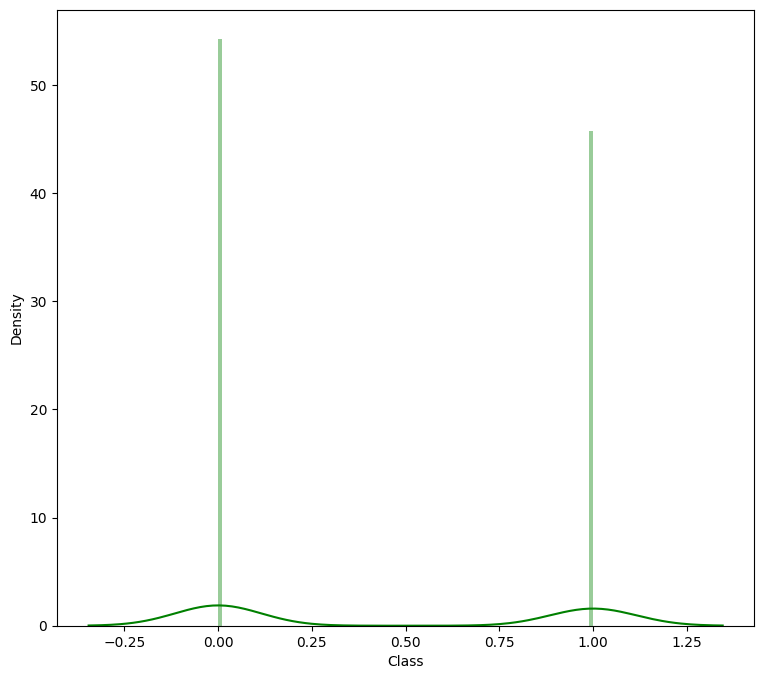

In [14]:
print(target['Class'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(target['Class'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [15]:
df_corr = df.drop("Class", axis=1).apply(lambda x: x.corr(df.Class))
golden_features_list = df_corr[abs(df_corr) > 0.35].sort_values(ascending=False)
print("There is {} correlated values with the target:\n{}".format(len(golden_features_list), golden_features_list))

There is 5 correlated values with the target:
Topological charge index of order 6 (TCI6)              0.371628
Connectivity index chi-5 (CIX5)                         0.367183
Topological charge index of order 4 (TCI4)              0.365977
Second Zagreb index by valence vertex degrees (ZM2V)    0.356586
Topological charge index of order 3 (TCI3)              0.353415
dtype: float64


In [16]:
sns_corr_df = df[list(golden_features_list.index.values)]
sns_corr_df['Class'] = target['Class']

/var/folders/vt/8kg_3c6554l1gb7hr4vbyjgr0000gn/T/ipykernel_3521/1408079542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sns_corr_df['Class'] = target['Class']


/opt/homebrew/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


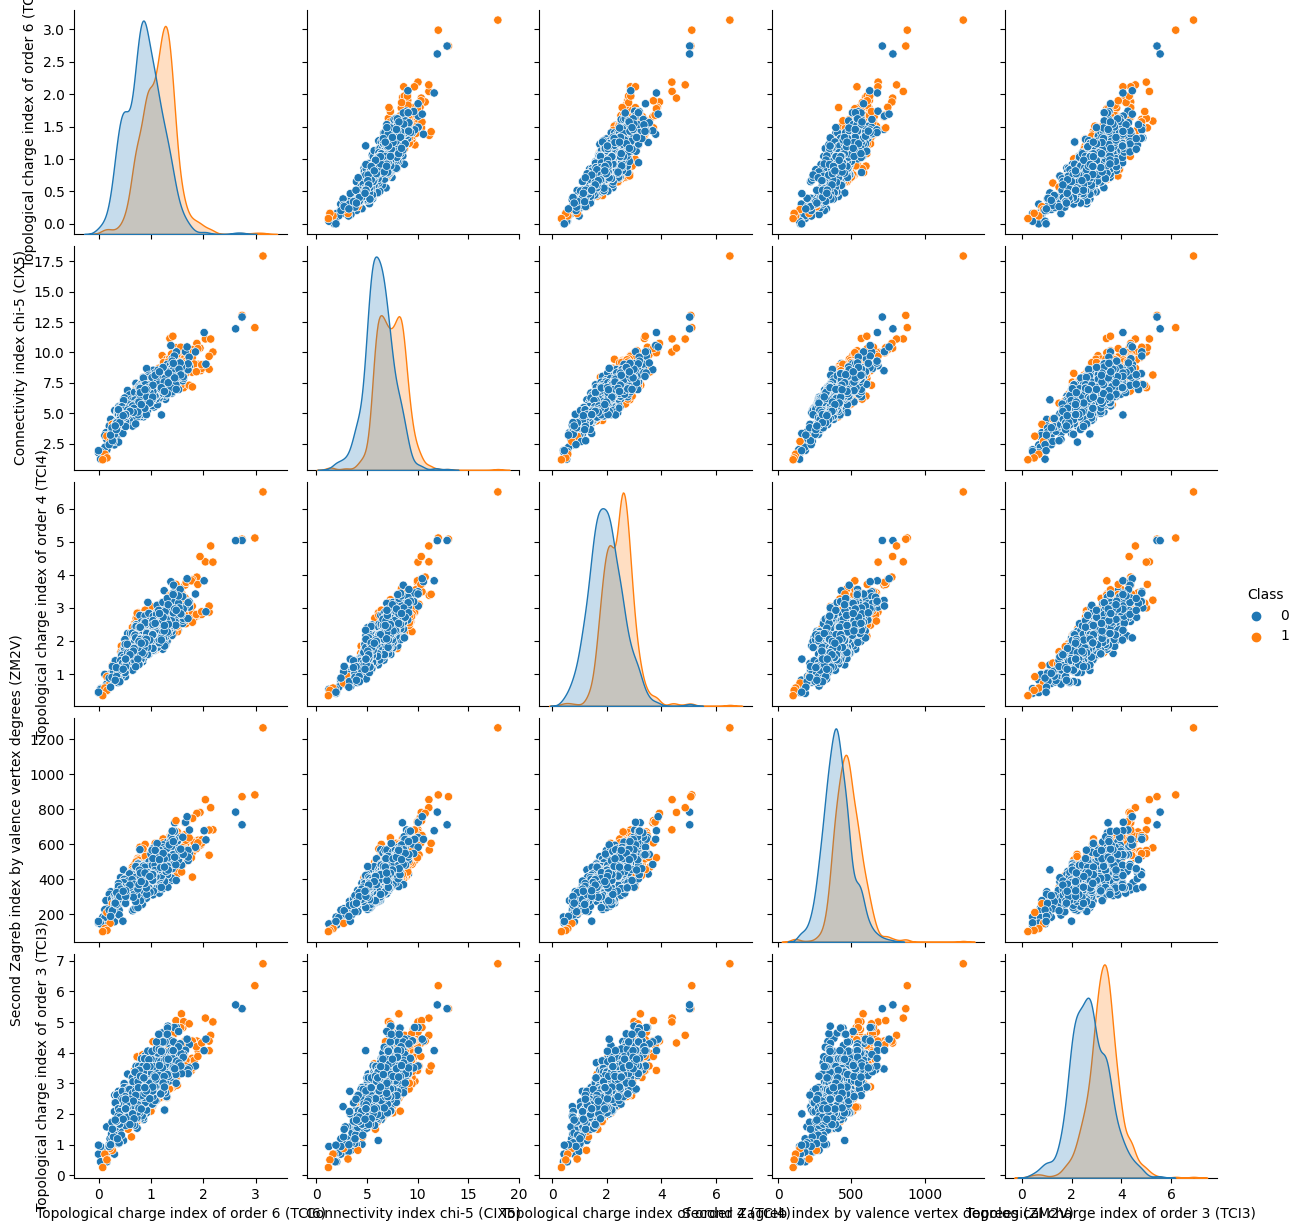

In [17]:
sns.pairplot(sns_corr_df, hue='Class', size=2.5)

In [18]:
data.head()

,MW,AlogP,HBA,HBD,RB,HeavyAtomCount,ChiralCenterCount,ChiralCenterCountAllPossible,RingCount,PSA,...,PEOE5 (PEOE5),PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14)
0,431.56979,4.4014,3,2,5,32,2,2,4,77.239998,...,0.0,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000
1,657.81073,2.6412,5,4,16,47,6,6,4,124.580000,...,0.0,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788
2,591.74091,2.5499,4,3,11,42,2,3,5,125.860000,...,0.0,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788
3,591.67828,3.1680,4,3,12,40,4,5,3,123.840000,...,0.0,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181
4,629.71283,3.5086,3,3,11,44,2,3,5,116.630000,...,0.0,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143


In [19]:
from sklearn import tree
X = data.values
y = target.values

In [22]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_oversampled, y_oversampled = oversample.fit_resample(X, y)

In [23]:
from sklearn.model_selection import train_test_split
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled, y_oversampled, test_size=0.33, stratify=y_oversampled, random_state=42)

In [24]:
from sklearn import tree
from sklearn.metrics import accuracy_score

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_oversampled_train, y_oversampled_train)

In [25]:
y_pred_train = clf.predict(X_oversampled_train)
accuracy_score(y_pred_train, y_oversampled_train)

0.9972826086956522

In [26]:
y_pred_test = clf.predict(X_oversampled_test)
accuracy_score(y_pred_test, y_oversampled_test)

0.7775735294117647

In [27]:
import numpy as np

In [28]:
np.unique(y_oversampled, return_counts=True)

(array([0, 1]), array([824, 824]))

In [29]:
list(data.columns[:-1])

['MW',
 'AlogP',
 'HBA',
 'HBD',
 'RB',
 'HeavyAtomCount',
 'ChiralCenterCount',
 'ChiralCenterCountAllPossible',
 'RingCount',
 'PSA',
 'Estate',
 'MR',
 'Polar',
 'sCH3_Key',
 'dCH2_Key',
 'ssCH2_Key',
 'tCH_Key',
 'dsCH_Key',
 'aaCH_Key',
 'sssCH_Key',
 'tsC_Key',
 'dssC_Key',
 'aasC_Key',
 'aaaC_Key',
 'ssssC_Key',
 'sNH3_Key',
 'sNH2_Key',
 'ssNH2_Key',
 'dNH_Key',
 'ssNH_Key',
 'aaNH_Key',
 'tN_Key',
 'sssNH_Key',
 'dsN_Key',
 'aaN_Key',
 'sssN_Key',
 'aasN_Key',
 'sOH_Key',
 'dO_Key',
 'ssO_Key',
 'aaO_Key',
 'aOm_Key',
 'sOm_Key',
 'sF_Key',
 'ssS_Key',
 'aaS_Key',
 'dssS_Key',
 'ddssS_Key',
 'sCl_Key',
 'sBr_Key',
 'sI_Key',
 'sCH3_Cnt',
 'dCH2_Cnt',
 'ssCH2_Cnt',
 'tCH_Cnt',
 'dsCH_Cnt',
 'aaCH_Cnt',
 'sssCH_Cnt',
 'tsC_Cnt',
 'dssC_Cnt',
 'aasC_Cnt',
 'aaaC_Cnt',
 'ssssC_Cnt',
 'sNH3_Cnt',
 'sNH2_Cnt',
 'ssNH2_Cnt',
 'dNH_Cnt',
 'ssNH_Cnt',
 'aaNH_Cnt',
 'tN_Cnt',
 'sssNH_Cnt',
 'dsN_Cnt',
 'aaN_Cnt',
 'sssN_Cnt',
 'aasN_Cnt',
 'sOH_Cnt',
 'dO_Cnt',
 'ssO_Cnt',
 'aaO_Cnt',
 

[Text(0.5235125968992248, 0.9833333333333333, 'x[195] <= 6.053\ngini = 0.5\nsamples = 1104\nvalue = [552, 552]'),
 Text(0.34124031007751937, 0.95, 'x[226] <= 0.397\ngini = 0.353\nsamples = 437\nvalue = [337, 100]'),
 Text(0.25953488372093025, 0.9166666666666666, 'x[178] <= 3.085\ngini = 0.231\nsamples = 360\nvalue = [312, 48]'),
 Text(0.2151937984496124, 0.8833333333333333, 'x[58] <= 1.5\ngini = 0.186\nsamples = 328\nvalue = [294, 34]'),
 Text(0.18604651162790697, 0.85, 'x[338] <= 247.283\ngini = 0.16\nsamples = 320\nvalue = [292, 28]'),
 Text(0.15751937984496123, 0.8166666666666667, 'x[152] <= 6.538\ngini = 0.375\nsamples = 4\nvalue = [1, 3]'),
 Text(0.1475968992248062, 0.7833333333333333, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.16744186046511628, 0.7833333333333333, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.21457364341085272, 0.8166666666666667, 'x[223] <= 1.121\ngini = 0.146\nsamples = 316\nvalue = [291, 25]'),
 Text(0.18728682170542635, 0.7833333333333333, 'x[

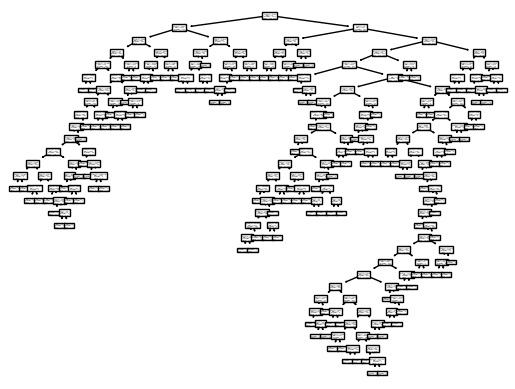

In [30]:
tree.plot_tree(clf)

In [31]:
input_shape = [X_oversampled_train.shape[1]]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'), 
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy',
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_oversampled_train, y_oversampled_train,
    validation_split=0.2,
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping]
)

In [48]:
X_sample = shap.kmeans(X_oversampled_train, 10)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [49]:
explainer = shap.KernelExplainer(model.predict, X_sample)

1/1 [==============================] - 0s 12ms/step


In [ ]:
shap_values_neural = explainer.shap_values(X_oversampled_test, nsamples=250)


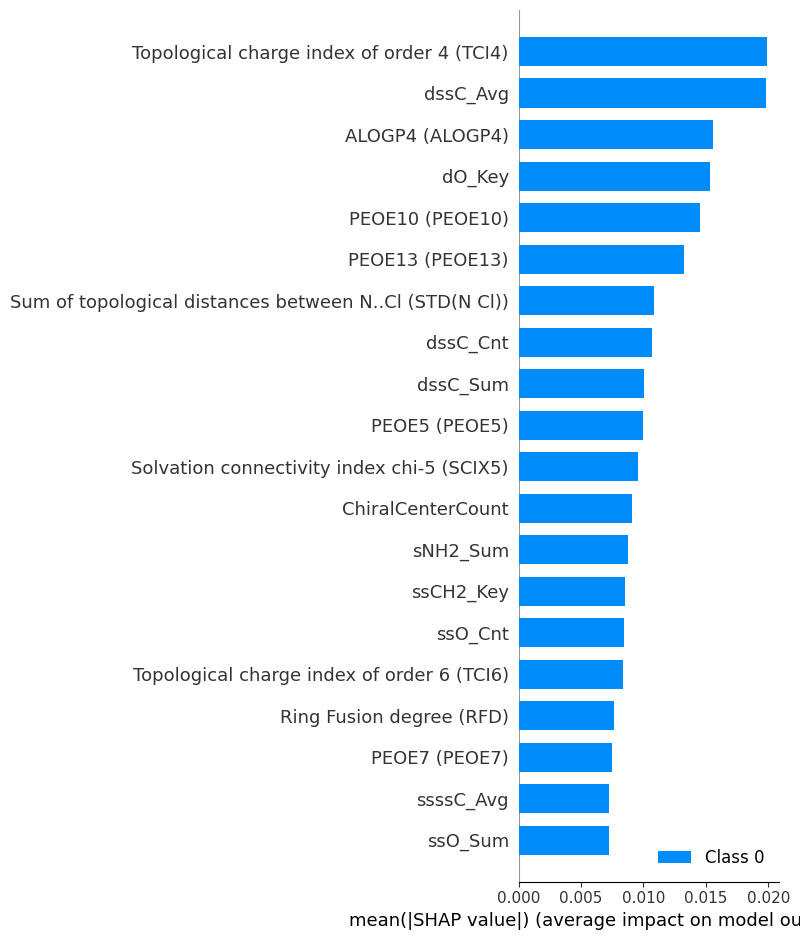

In [54]:
shap.summary_plot(shap_values_neural, X_oversampled_test, plot_type="bar", feature_names=list(data.columns))

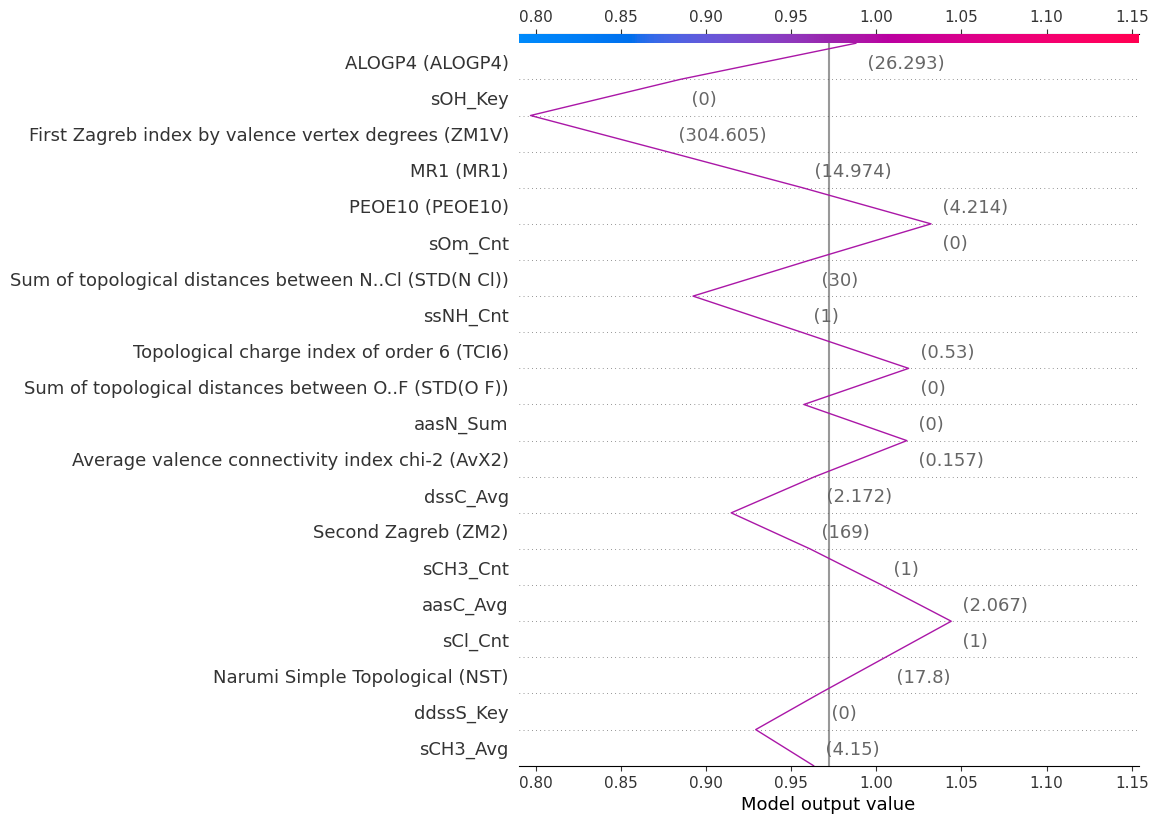

In [56]:
shap.decision_plot(
    explainer.expected_value[0], shap_values_neural[0][0], features = X_oversampled_test[0,:], feature_names = list(data.columns)
  )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


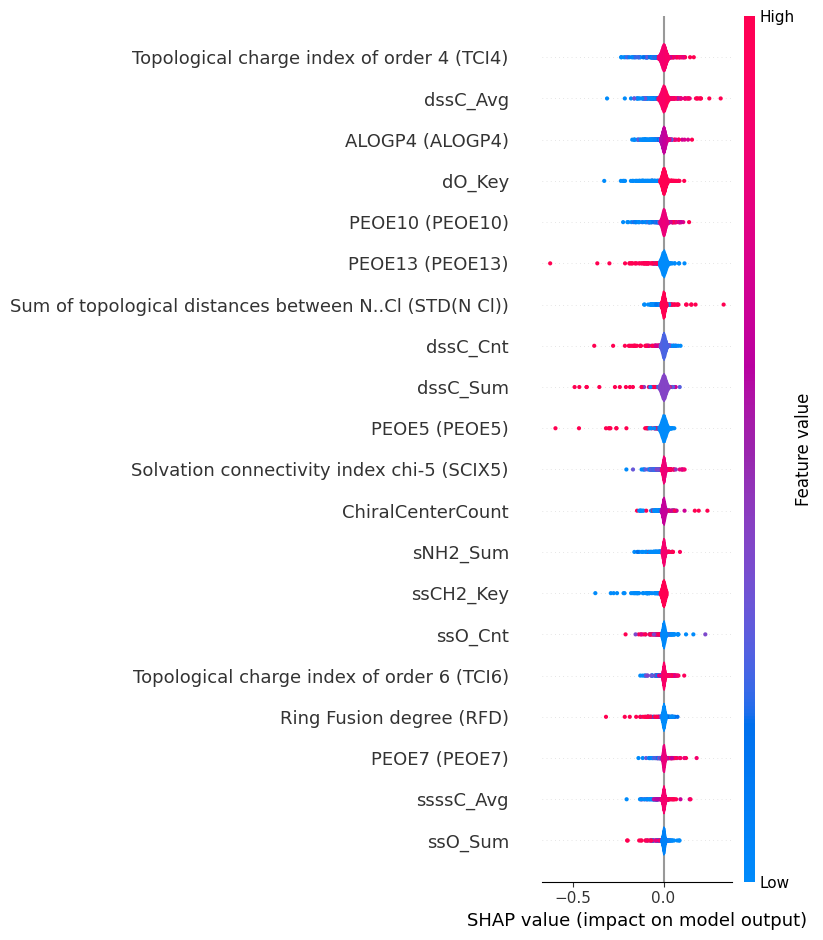

In [57]:
shap.summary_plot(shap_values_neural[0], X_oversampled_test, plot_type="violin", feature_names=list(data.columns))